# LSTM Model

This code uses the example of the following tutorials/codes: [Richard Cheng's fake news classification](https://github.com/itsuncheng/fake_news_classification), [Analytics Vidhya's Build First Text Classification](https://www.analyticsvidhya.com/blog/2020/01/first-text-classification-in-pytorch/), and our previous class homeworks.


In [1]:
!pip install torchtext==0.11.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.0 MB 25.0 MB/s 
     |██████████████████████████████▎ | 834.1 MB 1.2 MB/s eta 0:00:42tcmalloc: large alloc 1147494400 bytes == 0x38d08000 @  0x7f3132a43615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████████████████████| 881.9 MB 1.8 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.12.0
    Uninstalling torchtext-0.12.0:
      Successfully uninstalled torchtext-0.12.0
ERROR: pip's dependency resolver does 

In [2]:
import os
import sys
import torch
from torch.nn import functional as F
import numpy as np
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors, GloVe


In [ ]:
# from torchtext.vocab import GloVe

# glove = GloVe(name="twitter.27B", dim=25)

# glove.twitter.27B.25d

# glove = GloVe(name='6B')


.vector_cache/glove.twitter.27B.zip: 1.52GB [04:46, 5.31MB/s]                            
100%|█████████▉| 1193513/1193514 [00:24<00:00, 49621.04it/s]


In [3]:
from torchtext.vocab import GloVe
from itertools import combinations
from torchtext import vocab

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

if device == 'cpu':
    VECTORS_CACHE_DIR = '/Users/sophiamlawer/.vector_cache'
    # Please change above to your cache
else:
    VECTORS_CACHE_DIR = './.vector_cache'
    # This is the default cache on Colab. Caching may not work
    # as expected on Colab.



glove = vocab.GloVe(name="twitter.27B", dim=100,cache=VECTORS_CACHE_DIR)

./.vector_cache/glove.twitter.27B.zip: 1.52GB [04:46, 5.31MB/s]                            
100%|█████████▉| 1193513/1193514 [00:52<00:00, 22930.00it/s]


In [ ]:
## Read in data
import pandas as pd 

df_train = pd.read_csv("hate_upsampled_train.csv")
df_test = pd.read_csv("hate_upsampled_test.csv")
df_val = pd.read_csv("hate_upsampled_val.csv")

print(df_train.shape)
df_train.head()

(41608, 9)


,Unnamed: 0,Unnamed: 0.1,id,label,tweet,hash_tag,clean_tweet,tokenized_tweet,tokenized_tweet_NLTK
0,44049,15405,15406,0,@user we really are. lmaoo we are obviously re...,[],really lmaoo obviously related haha wonder cam...,<user> we really are. lmaoo we are obviously r...,@user really lmaoo obviously related haha wond...
1,33142,3684,3685,0,i think my #hea need a #bandage again ð #...,"['hea', 'bandage', 'love']",think hea need bandage love,i think my <hashtag> hea need a <hashtag> band...,think hea need bandage love
2,40964,12093,12094,0,new phone #xperiaz3+ #xperiaz4 #sony #thebeast...,"['xperiaz3', 'xperiaz4', 'sony', 'thebeast', '...",new phone xperiaz3 xperiaz4 sony thebeast copp...,new phone <hashtag> xperiaz<number>+ <hashtag>...,new phone xperiaz3 xperiaz4 sony thebeast copp...
3,53102,25149,25150,0,#dinner at my friend's #steak #shop never #d...,"['dinner', 'steak', 'shop', 'disappoint', 'yum...",dinner friends steak shop never disappoint yum...,<hashtag> dinner at my friend's <hashtag> st...,dinner friend's steak shop never disappoint yu...
4,15142,12744,12745,1,@user @user @user and sorry if we are ethnical...,[],sorry ethnically cleansing east jerusalem beth...,<user> <user> <user> and sorry if we are ethni...,@user @user @user sorry ethnically cleansing e...


In [ ]:
df_train = df_train[df_train['clean_tweet'].notna()]
df_test = df_test[df_test['clean_tweet'].notna()]
df_val = df_val[df_val['clean_tweet'].notna()]

df_train[["clean_tweet", "label"]].to_csv("train.csv")
df_test[["clean_tweet", "label"]].to_csv("test.csv")
df_val[["clean_tweet", "label"]].to_csv("val.csv")

In [ ]:
df_train[["clean_tweet", "label"]]

,clean_tweet,label
0,really lmaoo obviously related haha wonder cam...,0
1,think hea need bandage love,0
2,new phone xperiaz3 xperiaz4 sony thebeast copp...,0
3,dinner friends steak shop never disappoint yum...,0
4,sorry ethnically cleansing east jerusalem beth...,1
...,...,...
41603,invited help700 actions peace povey sept 1625,1
41604,might libtard libtard sjw liberal politics,1
41605,people arent protesting trump republican wonth...,1
41606,ppl playing statedey playing india future,0


## Try This Model

In [ ]:
from torchtext.legacy.data import Field, LabelField, TabularDataset, BucketIterator, Iterator

TEXT = Field(tokenize='spacy',batch_first=True,include_lengths=True)
LABEL = LabelField(sequential=False, use_vocab=False, dtype = torch.float,batch_first=True)

In [ ]:
# fields = [('label', LABEL), ('clean_tweet',TEXT)]
# fields = [('clean_tweet',TEXT)]
fields = [(None, None), ('clean_tweet',TEXT),('label', LABEL)]


In [ ]:
train, val, test = TabularDataset.splits(path = "/content/", train='train.csv',validation='val.csv',
                                         test='test.csv', format='csv',
                                         fields= fields, skip_header=True)

print(vars(train.examples[8]))

{'clean_tweet': ['dear', 'please', 'give', 'us', 'multiracial', 'objective', 'list', 'prove', 'selection'], 'label': '1'}


In [ ]:
TEXT.build_vocab(train,min_freq=3,vectors = "glove.twitter.27B.100d")  
# LABEL.build_vocab(train)

#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
# print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  
# print(LABEL.vocab.freqs.most_common(10))  

#Word dictionary
print(TEXT.vocab.stoi)   

Size of TEXT vocabulary: 10396
[('nt', 3678), ('love', 2114), ('like', 1965), ('trump', 1943), ('day', 1636), ('i', 1609), ('people', 1424), ('libtard', 1392), ('white', 1329), ('new', 1296)]
defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f7c57cad390>>, {'<unk>': 0, '<pad>': 1, 'nt': 2, 'love': 3, 'like': 4, 'trump': 5, 'day': 6, 'i': 7, 'people': 8, 'libtard': 9, 'white': 10, 'new': 11, 'black': 12, 'happy': 13, 'm': 14, 's': 15, 'do': 16, 'racist': 17, 'one': 18, 'time': 19, 'politics': 20, 'us': 21, 'allahsoil': 22, 'ca': 23, 'get': 24, 'good': 25, 'life': 26, 'today': 27, 'feel': 28, 'might': 29, 'liberal': 30, 'see': 31, 'women': 32, 'hate': 33, 'go': 34, 'retweet': 35, 'sjw': 36, 'want': 37, 're': 38, 'positive': 39, 'obama': 40, 'thankful': 41, 'you': 42, 'would': 43, 'racism': 44, 'listen': 45, 'via': 46, 'got': 47, 'bihday': 48, 'work': 49, 'make': 50, 'take': 51, 'great': 52, 'never': 53, 'think': 54, 'really': 55, 'need': 56,

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

#set batch size
BATCH_SIZE = 64

#Load an iterator
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train, val, test), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.clean_tweet),
    sort_within_batch=True,
    device = device)

In [7]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F

#hidden = [batch size, num layers * num directions,hid dim]
#cell = [batch size, num layers * num directions,hid dim]


class classifier(nn.Module):
    
    #define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, text, n_layers, 
                 bidirectional, dropout):
        
        #Constructor
        super().__init__()          
        self.embedding_dim = embedding_dim
        #embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data = text.vectors
        self.dropout = nn.Dropout(dropout)

        #lstm layer
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=True, 
                          #  dropout=dropout,
                           batch_first=True)
        
        #dense layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        # #activation function
        self.act = nn.Sigmoid()
        
    def forward(self, text, text_lengths):
        
        #text = [batch size,sent_length]
        embedded = self.embedding(text)
        #embedded = [batch size, sent_len, emb dim]

        #packed sequence
        packed_embedded = pack_padded_sequence(embedded, text_lengths,batch_first=True, 
                                                            enforce_sorted=False)
        
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        
        #concat the final forward and backward hidden state
        # hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        # dense_outputs=self.fc(hidden)
        # outputs=self.act(dense_outputs) 

        # hidden = [batch size, hid dim * num directions]

        out_forward = output[range(len(output)), text_lengths - 1, :self.embedding_dim]
        out_reverse = output[:, 0, self.embedding_dim:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        dense_outputs = self.dropout(out_reduced)
        dense_outputs=self.fc(dense_outputs)

        dense_outputs = torch.squeeze(dense_outputs, 1)
        outputs = torch.sigmoid(dense_outputs)
        #Final activation function
        # outputs=F.log_softmax(dense_outputs)
        return outputs

In [ ]:
size_of_vocab = len(TEXT.vocab)
embedding_dim = 100
num_hidden_nodes = 50
num_output_nodes = 1
num_layers = 2
dropout = 0.2

#instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes,num_output_nodes, TEXT.vocab, num_layers, 
                   bidirectional = True, dropout = dropout)

In [ ]:
#architecture
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

#Initialize the pretrained embedding
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

print(pretrained_embeddings.shape)

classifier(
  (embedding): Embedding(10396, 100)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(100, 50, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
  (act): Sigmoid()
)
The model has 1,161,301 trainable parameters
torch.Size([10396, 100])


In [ ]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#define optimizer and loss
optimizer = optim.Adam(model.parameters(),lr=0.00001)
criterion = nn.BCELoss()

In [19]:


#define metric
def binary_accuracy(preds, y):
    print("Sum of predicted",preds.sum())
    # print(y)
    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)

    accuracy = 0.0
    for i, y_ in enumerate(preds):
      if y_ == y[i]:
          accuracy += 1.0   
      accuracy = accuracy / len(preds)
      #print('Test Accuracy: ', accuracy)
              
      # print('Classification Report:')
      # print(classification_report(y, preds, labels=[1,0], digits=4))
      
    return acc
    
#push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

### Upsampled Strategy 1

In [9]:
def train(model, iterator, optimizer, criterion):
    
    #initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # #set the model in training phase
    # model.train()  
    
    for batch in iterator:
        #resets the gradients after every batch
        optimizer.zero_grad()   
        
        #retrieve text and no. of words
        text, text_lengths = batch.clean_tweet   
        #convert to 1D tensor
        predictions = model(text, text_lengths).squeeze() 
        #compute the loss
        loss = criterion(predictions, batch.label)        
        
        #compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        
        #backpropage the loss and compute the gradients
        loss.backward()       
        
        #update the weights
        optimizer.step()      
        
        #loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [10]:
def evaluate(model, iterator, criterion):
    
    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    #deactivating dropout layers
    model.eval()
    iter = 0

    #deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
            iter += 1
            #retrieve text and no. of words
            text, text_lengths = batch.clean_tweet
            
            #convert to 1d tensor
            predictions = model(text, text_lengths).squeeze()
            print(predictions)
            #compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)

            if iter % 100:
              print("Loss", loss)
              print("Acc", acc)
            
            #keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
N_EPOCHS = 10
best_valid_loss = float('inf')
#set the model in training phase
model.train()

for epoch in range(N_EPOCHS):
     
    #train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    #evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Streaming output truncated to the last 5000 lines.
tensor([0.4806, 0.4758, 0.4799, 0.4684, 0.4697, 0.4760, 0.4742, 0.4743, 0.4732,
        0.4747, 0.4720, 0.4727, 0.4728, 0.4774, 0.4740, 0.4738, 0.4780, 0.4757,
        0.4720, 0.4724, 0.4782, 0.4730, 0.4767, 0.4744, 0.4743, 0.4770, 0.4751,
        0.4765, 0.4724, 0.4766, 0.4757, 0.4763, 0.4722, 0.4763, 0.4749, 0.4765,
        0.4759, 0.4779, 0.4772, 0.4756, 0.4765, 0.4741, 0.4799, 0.4768, 0.4739,
        0.4760, 0.4775, 0.4740, 0.4721, 0.4806, 0.4755, 0.4746, 0.4741, 0.4764,
        0.4786, 0.4741, 0.4739, 0.4757, 0.4778, 0.4762, 0.4739, 0.4803, 0.4759,
        0.4757])
Sum of predicted tensor(30.4244)
Loss tensor(0.6992)
Acc tensor(0.4531)
tensor([0.4787, 0.4737, 0.4731, 0.4761, 0.4799, 0.4770, 0.4681, 0.4799, 0.4756,
        0.4775, 0.4776, 0.4839, 0.4762, 0.4785, 0.4781, 0.4761, 0.4706, 0.4758,
        0.4706, 0.4790, 0.4739, 0.4743, 0.4806, 0.4749, 0.4717, 0.4776, 0.4774,
        0.4767, 0.4747, 0.4739, 0.4769, 0.4746, 0.4764, 0.47

## Upsampled Strategy 2

In [11]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_full(model, test_loader, device='cpu'):
    '''
    Accepts the current best model and evaluates
    the test dataset. Printing test accuracy and
    an sklearn confusion matrix report.
    
    Inputs:
    - model: PyTorch model object, the current best model.
    - test_loader: an iterator with test data.
    - device: string, 'cpu' or 'cuda' if using google colab.
    
    Returns: None.
    
    Other Effects:
        Prints test accuracy.
        Prints an Accuracy / F1 Report (sklearn)
        Prints a Confusion Matrix (sklearn & matplotlib)
    '''
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for ((text, text_len),labels) in test_loader:           
            labels = labels.to(device)
            text = text.to(device)
            text_len = text_len.to(device)
            output = model(text, text_len)   
            output = torch.round(output)
            # torch.max(output, axis=1).indices
            #.indices
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())

    acc = 0.0
    for i, y in enumerate(y_pred):
        if y == y_true[i]:
            acc += 1.0
    
    acc = acc / len(y_pred)
    
    
    print('Test Accuracy: ', acc)
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['1','0'])
    ax.yaxis.set_ticklabels(['1','0'])
    
    return None

In [12]:
def save_checkpoint(save_path, model, optimizer, valid_loss):
    '''
    Used in train_model() to save the current best model.
    
    Inputs:
        - save_path: string, where to save model specs.
        - model: a PyTorch model object.
        - optimizer: a PyTorch Optimizer to be used.
        - train_loader: the iterator with training data.
        - valid_loss: float, current model loss.
        
    Returns: None.
    
    Other Effects:
        - Saves the best model's state dictionary to designated
        file path as 'model.pt'
    '''

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer, device='cpu'):
    '''
    Used in evaluate() to load the current best model.
    
    Inputs:
        - load_path: string, where to save model specs.
        - model: a PyTorch model object.
        - optimizer: a PyTorch Optimizer to be used.
        - device: string, 'cpu' or 'cuda' if using google colab.
        
    Returns: float, the models last validation loss.
    
    Other Effects:
        - Loads the saved state at load_path
        into the current model object
    '''
    if load_path==None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):
    '''
    Used in train_model() to save the current best model.
    
    Inputs:
        - save_path: string, where to save model specs.
        - train_loss_list: list of float, current model training losses.
        - valid_loss_list: list of float, current model validation losses.
        - global_steps_list: list of loss function calculation steps.
        
    Returns: None.
    
    Other Effects:
        - Saves the best model's loss history designated
        file path as 'metrics.pt'
    '''
    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path, device='cpu'):
    '''
    Used in evaluate() to load the current best model.
    
    Inputs:
        - load_path: string, where find model specs.
        - device: string, 'cpu' or 'cuda' if using google colab.
    Returns: tuple (train_loss_list, valid_loss_list, global_steps_list)
        - train_loss_list: list of float, current model training losses.
        - valid_loss_list: list of float, current model validation losses.
        - global_steps_list: list of loss function calculation steps.
    '''
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return (state_dict['train_loss_list'], 
            state_dict['valid_loss_list'], 
            state_dict['global_steps_list'])
        

In [13]:
def train_model(model,
                optimizer,
                train_loader,
                valid_loader,
                criterion = nn.CrossEntropyLoss(),
                num_epochs = 7,
                file_path = './data',
                best_valid_loss = float("Inf"),
                device='cpu'):
    '''
    Runs training and evaluation on validation data loop over specified number of epochs.
    
    Inputs:
        - model: a PyTorch model object. In this case, the one from lstm.py.
        - optimizer: a PyTorch Optimizer to be used.
        - train_loader: the iterator with training data.
        - valid_loader: the iterator with validation data.
        - criterion: a PyTorch loss function instance.
        - num_epochs: int, how many epochs to train over.
        - file_path: string, where to save model specs.
        - best_valid_loss: float, defaults to infinity to start training from scratch, 
            but if continuing from a prior run and wish to only save better outcomes,
            you can pass the last best model's loss.
        - device: string, 'cpu' or 'cuda' if running on google colab.
    
    Returns: None.
    
    Other Effects:
        - Saves the best model's state dictionary to designated
        file path as 'model.pt'
        - Saves loss history to designated file path as '/metrics.pt'
    '''
    
    eval_every = len(train_loader) // 2
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    model.train()

    # training loop
    for epoch in range(num_epochs):
        for ((text, text_len), labels) in train_loader:           
            labels = labels.to(device)
            text = text.to(device)
            text_len = text_len.to(device)
            output = model(text, text_len).squeeze()
            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for ((text, text_len), labels) in valid_loader:
                        labels = labels.to(device)
                        text = text.to(device)
                        text_len = text_len.to(device)
                        output = model(text, text_len).squeeze()
                        loss = criterion(output, labels)
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    print(best_valid_loss)
                    save_checkpoint('/model.pt', model, optimizer, best_valid_loss)
                    save_metrics('/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print(train_loss_list, valid_loss_list, global_steps_list)
    save_metrics('/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')
    
    return None

In [ ]:

import torch.optim as optim

SAVE_PATH = './data'
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

train_model(model=model,
            optimizer=optimizer,
            train_loader=train_iterator,
            valid_loader=valid_iterator,
            criterion = criterion,
            num_epochs = 20,
            file_path = SAVE_PATH,
            device="cpu")

Epoch [1/20], Step [325/13000], Train Loss: 0.2055, Valid Loss: 0.0815
0.0814746913408661
Model saved to ==> /model.pt
Model saved to ==> /metrics.pt
Epoch [1/20], Step [650/13000], Train Loss: 0.0650, Valid Loss: 0.0416
0.04159677991951217
Model saved to ==> /model.pt
Model saved to ==> /metrics.pt
Epoch [2/20], Step [975/13000], Train Loss: 0.0256, Valid Loss: 0.0334
0.0334215342497503
Model saved to ==> /model.pt
Model saved to ==> /metrics.pt
Epoch [2/20], Step [1300/13000], Train Loss: 0.0194, Valid Loss: 0.0242
0.024183453950016493
Model saved to ==> /model.pt
Model saved to ==> /metrics.pt
Epoch [3/20], Step [1625/13000], Train Loss: 0.0076, Valid Loss: 0.0232
0.023232126249786232
Model saved to ==> /model.pt
Model saved to ==> /metrics.pt
Epoch [3/20], Step [1950/13000], Train Loss: 0.0085, Valid Loss: 0.0197
0.01971637272976555
Model saved to ==> /model.pt
Model saved to ==> /metrics.pt
Epoch [4/20], Step [2275/13000], Train Loss: 0.0067, Valid Loss: 0.0261
Epoch [4/20], Step 

Model loaded from <== /model.pt
Test Accuracy:  0.9968574635241302
Classification Report:
              precision    recall  f1-score   support

           1     0.9944    0.9993    0.9969      4461
           0     0.9993    0.9944    0.9968      4449

    accuracy                         0.9969      8910
   macro avg     0.9969    0.9969    0.9969      8910
weighted avg     0.9969    0.9969    0.9969      8910



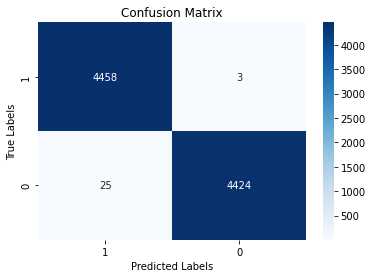

In [ ]:
# Evaluate
best_model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes,num_output_nodes, TEXT.vocab, num_layers, 
                   bidirectional = True, dropout = dropout)

optimizer = optim.Adam(best_model.parameters(), lr=0.00001)

load_checkpoint('/model.pt', best_model, optimizer)
evaluate_full(best_model, test_iterator)

## Prep Original

In [5]:
import pandas as pd
df_train = pd.read_csv("hate_train.csv")
df_test = pd.read_csv("hate_test.csv")
df_val = pd.read_csv("hate_val.csv")

print(df_train.shape)
df_train.head()
df_train = df_train[df_train['clean_tweet'].notna()]
df_test = df_test[df_test['clean_tweet'].notna()]
df_val = df_val[df_val['clean_tweet'].notna()]

df_train[["clean_tweet", "label"]].to_csv("train.csv")
df_test[["clean_tweet", "label"]].to_csv("test.csv")
df_val[["clean_tweet", "label"]].to_csv("val.csv")
df_train[["clean_tweet", "label"]]

from torchtext.legacy.data import Field, LabelField, TabularDataset, BucketIterator, Iterator

TEXT = Field(tokenize='spacy',batch_first=True,include_lengths=True)
LABEL = LabelField(sequential=False, use_vocab=False, dtype = torch.float,batch_first=True)
fields = [(None, None), ('clean_tweet',TEXT),('label', LABEL)]
train, val, test = TabularDataset.splits(path = "/content/", train='train.csv',validation='val.csv',
                                         test='test.csv', format='csv',
                                         fields= fields, skip_header=True)

print(vars(train.examples[8]))
TEXT.build_vocab(train,min_freq=3,vectors = "glove.twitter.27B.100d")  
# LABEL.build_vocab(train)

#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
# print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  
# print(LABEL.vocab.freqs.most_common(10))  

#Word dictionary
print(TEXT.vocab.stoi)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

#set batch size
BATCH_SIZE = 64

#Load an iterator
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train, val, test), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.clean_tweet),
    sort_within_batch=True,
    device = device)

(22373, 9)
{'clean_tweet': ['i', 'm', 'london', 'tomorrow', 'blogtacular', 'full', 'planning', 'prep', 'blogger'], 'label': '0'}
Size of TEXT vocabulary: 7559
[('love', 1886), ('nt', 1708), ('day', 1617), ('happy', 1163), ('i', 1027), ('m', 839), ('life', 810), ('time', 804), ('like', 737), ('today', 708)]
defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7fccd58efe90>>, {'<unk>': 0, '<pad>': 1, 'love': 2, 'nt': 3, 'day': 4, 'happy': 5, 'i': 6, 'm': 7, 'life': 8, 'time': 9, 'like': 10, 'today': 11, 'new': 12, 'thankful': 13, 'positive': 14, 'get': 15, 'bihday': 16, 'people': 17, 'good': 18, 'ca': 19, 'one': 20, 'see': 21, 'fathers': 22, 'do': 23, 'smile': 24, 's': 25, 'go': 26, 'want': 27, 'take': 28, 'work': 29, 'healthy': 30, 'weekend': 31, 'fun': 32, 'friday': 33, 'got': 34, 'summer': 35, 'family': 36, 'make': 37, 'great': 38, 'best': 39, 'us': 40, 'need': 41, 'way': 42, 'beautiful': 43, 'bull': 44, 'first': 45, 'friends': 46, 'days': 47

In [15]:
size_of_vocab = len(TEXT.vocab)

embedding_dim = 100
num_hidden_nodes = 50
num_output_nodes = 1
num_layers = 2
dropout = 0.2

#instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes,num_output_nodes, TEXT.vocab, num_layers, 
                   bidirectional = True, dropout = dropout)
#architecture
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

#Initialize the pretrained embedding
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

print(pretrained_embeddings.shape)

optimizer = optim.Adam(model.parameters(),lr=0.00001)
criterion = nn.BCELoss()


classifier(
  (embedding): Embedding(7559, 100)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(100, 50, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
  (act): Sigmoid()
)
The model has 877,601 trainable parameters
torch.Size([7559, 100])


### Strategy 1

In [20]:

import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

N_EPOCHS = 10
best_valid_loss = float('inf')
#set the model in training phase
model.train()

#define optimizer and loss
optimizer = optim.Adam(model.parameters(),lr=0.00001)
criterion = nn.BCELoss()

for epoch in range(N_EPOCHS):
     
    #train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    #evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Streaming output truncated to the last 5000 lines.
Loss tensor(0.4037)
Acc tensor(0.9219)
tensor([5.6725e-06, 9.1102e-04, 3.0967e-06, 3.9884e-06, 3.9884e-06, 2.7521e-05,
        3.9884e-06, 1.9166e-06, 9.8267e-02, 1.1486e-03, 1.4945e-02, 1.5329e-05,
        3.4614e-05, 1.5296e-06, 1.2075e-04, 4.0146e-03, 8.8695e-06, 2.8773e-05,
        9.9980e-01, 1.6847e-06, 1.0145e-01, 7.4588e-02, 3.9884e-06, 5.0449e-05,
        1.0808e-04, 3.9759e-06, 1.1167e-04, 1.4458e-05, 5.7012e-04, 2.2709e-06,
        1.1033e-05, 1.5072e-05, 2.2221e-05, 7.0071e-06, 7.1465e-06, 5.5575e-05,
        1.1353e-04, 8.2842e-05, 9.1041e-05, 1.0792e-05, 1.7982e-05, 1.1557e-03,
        1.1216e-06, 3.3066e-06, 1.1796e-05, 1.3180e-04, 1.4799e-05, 1.1284e-06,
        1.0294e-06, 3.9884e-06, 3.9884e-06, 5.2341e-06, 4.1567e-05, 2.1545e-03,
        3.9293e-06, 2.5396e-06, 3.9884e-06, 7.7134e-06, 5.8068e-06, 2.5641e-06,
        2.6783e-05, 4.5633e-03, 4.8740e-05, 3.1724e-04])
Sum of predicted tensor(1.3052)
Loss tensor(0.2235)
A

### Strategy 2

In [16]:
SAVE_PATH = './data'
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

train_model(model=model,
            optimizer=optimizer,
            train_loader=train_iterator,
            valid_loader=valid_iterator,
            criterion = criterion,
            num_epochs = 20,
            file_path = SAVE_PATH,
            device="cpu")

Epoch [1/20], Step [175/7000], Train Loss: 0.2249, Valid Loss: 0.1568
0.15684693338970343
Model saved to ==> /model.pt
Model saved to ==> /metrics.pt
Epoch [1/20], Step [350/7000], Train Loss: 0.1511, Valid Loss: 0.1351
0.13509278620282808
Model saved to ==> /model.pt
Model saved to ==> /metrics.pt
Epoch [2/20], Step [525/7000], Train Loss: 0.1071, Valid Loss: 0.1412
Epoch [2/20], Step [700/7000], Train Loss: 0.0959, Valid Loss: 0.1175
0.11750506459424893
Model saved to ==> /model.pt
Model saved to ==> /metrics.pt
Epoch [3/20], Step [875/7000], Train Loss: 0.0672, Valid Loss: 0.1268
Epoch [3/20], Step [1050/7000], Train Loss: 0.0689, Valid Loss: 0.1275
Epoch [4/20], Step [1225/7000], Train Loss: 0.0405, Valid Loss: 0.1476
Epoch [4/20], Step [1400/7000], Train Loss: 0.0463, Valid Loss: 0.1367
Epoch [5/20], Step [1575/7000], Train Loss: 0.0306, Valid Loss: 0.1554
Epoch [5/20], Step [1750/7000], Train Loss: 0.0253, Valid Loss: 0.1640
Epoch [6/20], Step [1925/7000], Train Loss: 0.0159, Val

Model loaded from <== /model.pt
Test Accuracy:  0.9601419031719532
Classification Report:
              precision    recall  f1-score   support

           1     0.7826    0.5607    0.6534       321
           0     0.9691    0.9888    0.9789      4471

    accuracy                         0.9601      4792
   macro avg     0.8759    0.7748    0.8161      4792
weighted avg     0.9566    0.9601    0.9571      4792



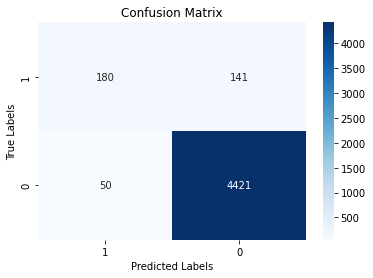

In [17]:
# Evaluate
best_model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes,num_output_nodes, TEXT.vocab, num_layers, 
                   bidirectional = True, dropout = dropout)

optimizer = optim.Adam(best_model.parameters(), lr=0.00001)

load_checkpoint('/model.pt', best_model, optimizer)
evaluate_full(best_model, test_iterator)